# Импорты и константы

In [26]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch.nn as nn
from os import listdir
from os.path import isfile, join

mypath = 'data'
CSV_DIRS  = [join(mypath, f) for f in listdir(mypath) if (isfile(join(mypath, f)) and not f.startswith('.'))]  #это пути к файлам с данными


SERIES_WINDOW = 40# длина окна для одного объекта Х
Y_WINDOW = 20

#SCALE_FEATURES = ['o', 'c', 'h', 'l', 'v']

SCALE_FEATURES = {'o':'o',
                  'c':'o',
                  'h':'o',
                  'l':'o', 
                  'v':'v'} #Я не знаю как будет меняться формат
#наших данных, поэтому те колонки, которые необходимо отмасштабировать нужно 
#вносить в этот список

SCALE_FEATURE = 'o'

BATCH_SIZE = 20

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
CSV_DIRS[11]

cpu


'data/COST - 2021-01-13.csv'

# PyTorch DataSet

In [17]:
class TimeSeriesDataSet(Dataset):
    #window - окно назад. y_window - окно вперед?
    def __init__(self, csv_dirs, window, d_type, split, y_window):
        # почему paths определяется через self?
        self.paths = csv_dirs
        dfs = []
        for path in self.paths:
            df = pd.read_csv(path, index_col=0)
            if d_type == 'train':
              df = df.iloc[:int(split*len(df))]
            else:
              df = df.iloc[int(split*len(df))-window:]

            df = df.fillna(value={'POSITIVE':0, 'NEGATIVE': 0})
            dfs.append(self.normalize(df, SCALE_FEATURES, SCALE_FEATURE))
        self.dfs = dfs
        
        self.dss = self.agg_ds(window, y_window)
        self.lenth = len(self.dss)

    def __len__(self):
        return self.lenth

    def __getitem__(self, idx):
        return self.dss[idx][1], self.dss[idx][0]
        

    def agg_ds(self, window, y_window):
      dss = []
      for df in self.dfs:
        dss = [*dss, *self.make_pd_ds(df, window, y_window)]
      return dss
        
        

    def make_pd_ds(self, df, window, y_window):        
      df = df.reset_index()
      ds_set = []
      counter = window + y_window
      #??? как работает каунтер ??
      while counter < df.shape[0]:
        y = df['c'][counter]
        temp = df.drop(columns=['date', 'index'])
        x = np.array(temp[counter-window-y_window:counter-y_window])
        ds_set.append([y, x])
        counter += 1
      return ds_set


    def normalize(self, df, scale_features, scale_feature):
      scale_obj = df.iloc[0]
      scale_obj
      for feature in scale_features.keys():
         df[feature] = df[feature]/scale_obj[scale_features[feature]] *100

      return df

        
        


In [33]:
def make_data_loaders(split, csv_dirs, window, batch_size, y_window):
  ds_train = TimeSeriesDataSet(
        d_type= 'train',
        window = window,
        split=split,
        csv_dirs = csv_dirs, 
        y_window = y_window

      )
  # from torch library 
  train = DataLoader(
      ds_train,
      batch_size = batch_size,
      shuffle= False)
  print(f"train lenth: {ds_train.lenth}")

  
  ds_test = TimeSeriesDataSet(
        d_type= 'test',
        window = window,
        split= split,
        csv_dirs = csv_dirs, 
        y_window = y_window

      )
  test = DataLoader(
      ds_test,
      batch_size = batch_size,
      shuffle= False)
  print(f"test lenth: {ds_test.lenth}")
  
  return train, test

# LSTM Model Init

In [27]:
# тензор для универсальной модели
train_data_loader,test_data_loader = make_data_loaders(0.8,
                                                       CSV_DIRS,
                                                       SERIES_WINDOW,
                                                       BATCH_SIZE,
                                                       Y_WINDOW)
# создаем список тензоров для отд моделей
data_loaders = []
for i in CSV_DIRS:
  data_loaders.append(make_data_loaders(0.8,
                                                        [i],
                                                       SERIES_WINDOW,
                                                       BATCH_SIZE,
                                                       Y_WINDOW))
#data_loaders

train lenth: 10119
test lenth: 2114
train lenth: 109
test lenth: 23
train lenth: 127
test lenth: 27
train lenth: 120
test lenth: 25
train lenth: 121
test lenth: 26
train lenth: 115
test lenth: 24
train lenth: 128
test lenth: 28
train lenth: 55
test lenth: 9
train lenth: 120
test lenth: 25
train lenth: 60
test lenth: 11
train lenth: 134
test lenth: 29
train lenth: 45
test lenth: 7
train lenth: 130
test lenth: 28
train lenth: 133
test lenth: 29
train lenth: 118
test lenth: 25
train lenth: 128
test lenth: 28
train lenth: 117
test lenth: 25
train lenth: 125
test lenth: 27
train lenth: 122
test lenth: 26
train lenth: 113
test lenth: 24
train lenth: 135
test lenth: 29
train lenth: 137
test lenth: 30
train lenth: 126
test lenth: 27
train lenth: 52
test lenth: 9
train lenth: 115
test lenth: 24
train lenth: 0
test lenth: 0
train lenth: 128
test lenth: 27
train lenth: 112
test lenth: 24
train lenth: 109
test lenth: 23
train lenth: 136
test lenth: 30
train lenth: 120
test lenth: 26
train lenth: 1

In [ ]:
next(iter(train_data_loader))

[tensor([[[102.4583],
          [104.6252],
          [104.0532],
          [103.8662],
          [102.7333],
          [101.6114],
          [ 97.5307],
          [ 99.2905],
          [100.0935],
          [100.5555],
          [103.3713],
          [102.0404],
          [101.9414],
          [111.7637],
          [111.3018],
          [113.0287],
          [113.5566],
          [114.1836],
          [113.2486],
          [112.5777],
          [112.4677],
          [110.8728],
          [106.2311],
          [106.0551],
          [105.2522],
          [104.6032],
          [105.1642],
          [108.5849],
          [106.4181],
          [103.0743],
          [100.6875],
          [101.8314],
          [ 98.1246],
          [101.7434],
          [100.4345],
          [102.2274],
          [102.3318],
          [102.6013],
          [101.6774],
          [ 98.5316],
          [ 99.5325],
          [101.0504],
          [100.5115],
          [ 99.5545],
          [ 99.9285],
          

In [32]:
class MV_LSTM(torch.nn.Module):
    def __init__(self,n_features,seq_length):
        super(MV_LSTM, self).__init__()
        ## задаем основные параметры
        self.n_features = n_features ## кол-во переменных (o,c,h,l,v,pos,neg = 7)?
        self.seq_len = seq_length ## длинна окна X ?
        self.n_hidden = 50 # number of hidden states. ## Почему 50? Не должно быть равно временному окну X? Как определяется? Или это количество вещей, которые надо запомнить?
        self.n_layers = 10 # number of LSTM layers (stacked). ## ИНтересно на что влияет увеличение слоев? Ведь инфо о паттернах есть уже в первом. 
        

        ## здесь задаем LSTM модель(?), внутри указано кол-во слоев. ДА
        self.l_lstm = torch.nn.LSTM(input_size = n_features, ## почему тут не self.n_features ? вообще ссылка на self для переменных не обязательна внутри класса? 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True,
                                 dropout = 0.5) ## работает на каждый слой внутри LSTM
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, 1) ## финальный слой? почему длинный, а не 1 число? 

        self.dropout = self.dropout = nn.Dropout(0.5) ## два раза "=" ?
        
    ## зачем эта функция? 
    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden,device= device)
        cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden,device= device)
        self.hidden = (hidden_state, cell_state)
    
    
    def forward(self, x):        
        batch_size, seq_len, _ = x.size()
        
        ## получается мы hidden подаем и на вход, и получаем его на выходе? для чего?
        ## Почему lstm_out без self?
        lstm_out, self.hidden = self.l_lstm(x,self.hidden)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size,-1)
        x = self.dropout(x)
        return self.l_linear(x) ## почему возвращается длинный слой (кол-во фич * размер окна)? А не одно число? 

In [34]:
n_features = 8 # this is number of parallel inputs. Почему 8, [o,c,h,l,v,pos,neg] = 7? 
n_timesteps = SERIES_WINDOW # this is number of timesteps

# create NN
mv_net = MV_LSTM(n_features,n_timesteps).float() ##зачем добавляется float?
criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
optimizer = torch.optim.Adam(mv_net.parameters(), lr=1e-4)

epochs = 300

# Model train

### One model to all stocks

In [36]:
#Проблема: модель выдает одно и то же число
#Решение: дропаут, повторение значений лстм, посмотреть как правильно строить lstm сети
mv_net.to(device) ##перевод на GPU
mv_net.train() ## переводим модель в режим обучения 

train_loss = []
test_loss = []
avg_train_loss = []
avg_test_loss = []
for t in range(epochs):
    counter = 0
    output_train = 0
    labels_train = 0
    output_test = 0
    labels_test = 0
    print('---------------------------------epoch : ' ,
          t, '---------------------------------')
    
    sum_train = 0
    sum_test = 0
    for X, y in train_data_loader:
        ## init_hidden - это слой? или просто данные для старта?
        mv_net.init_hidden(X.size(0))
    #    lstm_out, _ = mv_net.l_lstm(x_batch,nnet.hidden)    
    #    lstm_out.contiguous().view(x_batch.size(0),-1)
        output_train = mv_net(X.float().to(device)) ## подаем X на вход
        loss = criterion(output_train.view(-1), y.float().to(device))
        train_loss.append(loss.item())
        sum_train += loss.item()
        
        with torch.no_grad():
          for X_t, y_t in test_data_loader:
              pred = mv_net(X.float().to(device))
              output_test = pred
              labels_test = y_t
              test_loss.append(criterion(pred.view(-1), y.to(device)).item())
              sum_test += test_loss[-1]
              break

        if(counter % 500 == 0):
          print("batch #", counter, " loss: ", train_loss[-1])
          print(f'test_loss: {test_loss[-1]}')



        loss.backward()
        optimizer.step()        
        optimizer.zero_grad() 

        labels_train = y
        counter += 1

    avg_train_loss.append(sum_train/counter)
    avg_test_loss.append(sum_test/counter)
    print()
    print(f"avg_train_loss = {sum_train/counter}")
    print(f"avg_train_loss = {sum_test/counter}")
    print()
    print('Check output of NN:')
    print(' train:')
    print(f'    out: {output_train.view(-1)}')
    print(f'    labels: {labels_train}')
    print(' test:')
    print(f'    out: {output_test.view(-1)}')
    print(f'    labels: {labels_test}')




    

---------------------------------epoch :  0 ---------------------------------
batch # 0  loss:  4309.2763671875
test_loss: 3902.112334597816
batch # 500  loss:  125.20565032958984
test_loss: 116.75888760699672

avg_train_loss = 1432.235506221711
avg_train_loss = 1254.3873576741591

Check output of NN:
 train:
    out: tensor([109.4857,  99.0144, 103.0906, 103.6736, 108.6487, 103.7715, 102.0362,
        108.5020, 106.6477, 104.6605, 100.1843, 103.7233, 102.6231, 100.9704,
        104.6555, 102.3251, 106.9665, 105.0836, 103.0401],
       grad_fn=<ViewBackward0>)
    labels: tensor([ 95.7381,  94.9969,  96.7601,  95.8729,  95.3226,  95.7381,  93.5707,
         95.0306,  96.0975,  94.9520,  96.4119,  95.8280,  98.0403,  97.0689,
         97.0689, 100.2021, 113.2124, 112.4825, 109.3155], dtype=torch.float64)
 test:
    out: tensor([109.1117, 111.9310, 110.0733, 113.2390, 110.5020, 105.2485, 109.8788,
        109.2669, 109.1500, 114.5420, 107.8181, 108.7096, 108.4491, 107.9701,
        101.8

KeyboardInterrupt: 

65.63689446118909

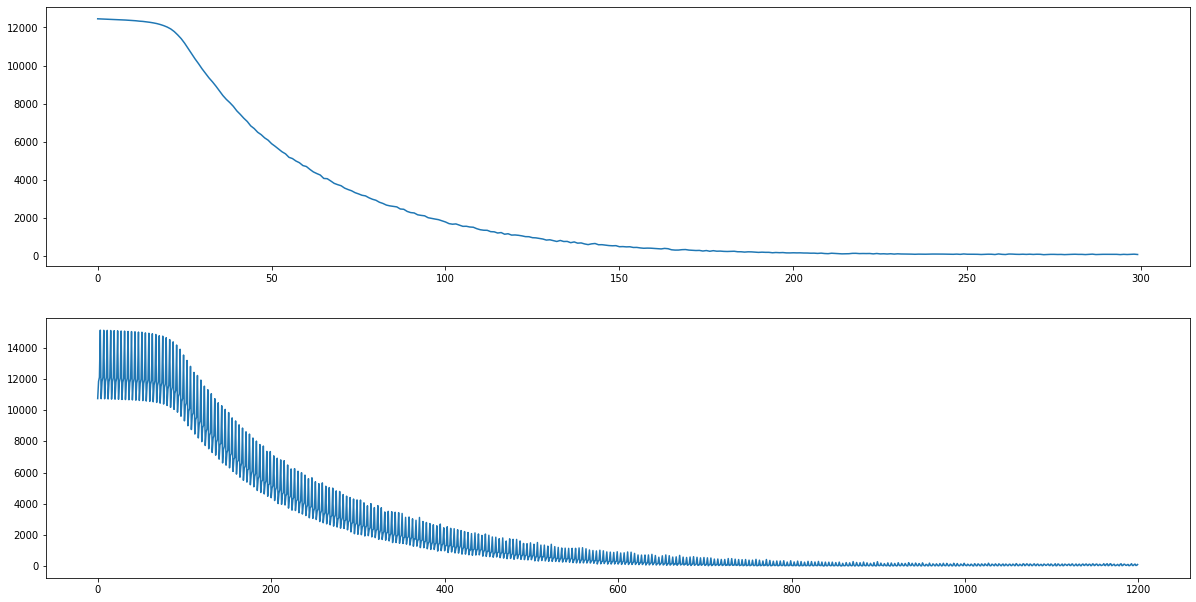

In [ ]:
fig, axes = plt.subplots(2)
axes[0].plot(range(len(avg_train_loss)), avg_train_loss)
axes[1].plot(range(len(test_loss)), test_loss)

fig.set_size_inches(20.5, 10.5)
avg_train_loss[-1]
min(avg_test_loss)

### Models for every stock

In [37]:
loss_dict = {}
for i in range(len(CSV_DIRS)):
  n_features = 8 # this is number of parallel inputs
  n_timesteps = SERIES_WINDOW # this is number of timesteps

  # create NN
  mv_net = MV_LSTM(n_features,n_timesteps).float()
  criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
  optimizer = torch.optim.Adam(mv_net.parameters(), lr=1e-4)

  epochs = 400
  print(f'------------------------------------------------------------------#{i} {CSV_DIRS[i]}' 
          , '------------------------------------------------------------------')
  mv_net.to(device)
  mv_net.train()
  train_loss = []
  test_loss = []
  avg_train_loss = []
  avg_test_loss = []
  train_data_loader = data_loaders[i][0]
  test_data_loader = data_loaders[i][1]
  for t in range(epochs):
      counter = 0
      output_train = 0
      labels_train = 0
      output_test = 0
      labels_test = 0
      #print('---------------------------------epoch : ' ,
      #    t, '---------------------------------')
    
      sum_train = 0
      sum_test = 0
      for X, y in train_data_loader:
          mv_net.init_hidden(X.size(0))
    #      lstm_out, _ = mv_net.l_lstm(x_batch,nnet.hidden)    
    #     lstm_out.contiguous().view(x_batch.size(0),-1)
          output_train = mv_net(X.float().to(device))
          loss = criterion(output_train.view(-1), y.float().to(device))
          train_loss.append(loss.item())
          sum_train += loss.item()
        
          with torch.no_grad():
            for X_t, y_t in test_data_loader:
                pred = mv_net(X.float().to(device))
                output_test = pred
                labels_test = y_t
                test_loss.append(criterion(pred.view(-1), y.to(device)).item())
                sum_test += test_loss[-1]
                break

          #if(counter % 5 == 0):
          #  print("batch #", counter, " loss: ", train_loss[-1])
          #  if len(test_loss) != 0:
          #    print(f'test_loss: {test_loss[-1]}')



          loss.backward()
          optimizer.step()        
          optimizer.zero_grad() 

          labels_train = y
          counter += 1

      avg_train_loss.append(1e+10 if counter == 0 else sum_train/counter)
      avg_test_loss.append(1e+10 if counter == 0 else sum_test/counter)
      #print()
      #print(f"avg_train_loss = {sum_train/counter}")
      #print(f"avg_train_loss = {sum_test/counter}")
      #print()
      #print('Check output of NN:')
      #print(' train:')
      #print(f'    out: {output_train.view(-1)}')
      #print(f'    labels: {labels_train}')
      #print(' test:')
      #print(f'    out: {output_test.view(-1)}')
      #print(f'    labels: {labels_test}')
  index = min(enumerate(avg_test_loss), key = lambda x: x[1])[0]
  print(min(avg_test_loss))
  loss_dict[CSV_DIRS[i]] = (avg_train_loss[index], avg_test_loss[index])
  print(f'index: {index} losses: {loss_dict[CSV_DIRS[i]]}')

------------------------------------------------------------------#0 data/FAST - 2021-01-13.csv ------------------------------------------------------------------
11.172304301564745
index: 103 losses: (31.500096638997395, 11.172304301564745)
------------------------------------------------------------------#1 data/ILMN - 2021-01-13.csv ------------------------------------------------------------------
105.81674042635385
index: 107 losses: (132.06545516422815, 105.81674042635385)
------------------------------------------------------------------#2 data/ADP - 2021-01-13.csv ------------------------------------------------------------------
30.258195296188905
index: 140 losses: (42.76372289657593, 30.258195296188905)
------------------------------------------------------------------#3 data/EXC - 2021-01-13.csv ------------------------------------------------------------------
37.76859431717953
index: 104 losses: (84.77018792288644, 37.76859431717953)
--------------------------------------

In [38]:
df = pd.DataFrame(loss_dict).T
df.columns = ['train_loss', 'test_loss']
df
df['test_loss_rmse'] = np.sqrt(df['test_loss'])
np.mean(df[df['test_loss_rmse'] < 100])

train_loss        514.100352
test_loss          84.926816
test_loss_rmse      7.546080
dtype: float64

In [ ]:
df.to_csv('losses_20d.csv')

# Garbage

In [ ]:
mv_net.eval()
for X, y in train_data_loader:
  print(f'out:{mv_net(X.float())}')
  print(f'y:{y}')
  break

RuntimeError: ignored

In [ ]:
mv_net.eval()
mv_net(X.float()), y

(tensor([[111.2561]], grad_fn=<AddmmBackward0>),
 tensor([90.4900], dtype=torch.float64))

In [ ]:
x1 = np.linspace(5,50, 100)
x2 = np.linspace(20,65, 100)
y = x1 + x2

X = torch.tensor(list(zip(x1.astype(np.float32),x2.astype(np.float32))))
Y = torch.tensor(y[:,np.newaxis].astype(np.float32))


In [ ]:
model = nn.Linear(2,1)

loss = nn.MSELoss()
opt = torch.optim.SGD(model.parameters(), lr = 0.01)

n_iter = 9
model.train()
for i in range(n_iter):
  y_pred = model(X)
  loss_fn = loss(y_pred, Y)
  loss_fn.backward()
  opt.step()
  opt.zero_grad()
  print(f"epoch #{i} loss: {loss_fn.item()}")

epoch #0 loss: 6657.37744140625
epoch #1 loss: 21543512.0
epoch #2 loss: 69715935232.0
epoch #3 loss: 225604515397632.0
epoch #4 loss: 7.300678181034394e+17
epoch #5 loss: 2.362537980497731e+21
epoch #6 loss: 7.645295739444594e+24
epoch #7 loss: 2.4740586618183177e+28
epoch #8 loss: 8.0061808745250915e+31


In [ ]:
from sklearn import datasets
X, y = datasets.make_regression(n_samples=100, n_features=3, noise=2, random_state=1)

X = torch.from_numpy(X.astype(np.float32))
y = torch.from_numpy(y.astype(np.float32))
y = y.view(y.shape[0],1)

n_samples, n_features = X.shape

input_size = n_features
output_size = 1
model = nn.Linear(input_size, output_size)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

num_epochs = 1000
for epoch in range(num_epochs):
  y_pred = model(X)
  loss = criterion(y_pred, y)

  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  print(f"epoch: {epoch} loss {loss.item()}")

epoch: 0 loss 11899.2109375
epoch: 1 loss 11517.6201171875
epoch: 2 loss 11148.7509765625
epoch: 3 loss 10792.1650390625
epoch: 4 loss 10447.43359375
epoch: 5 loss 10114.150390625
epoch: 6 loss 9791.9140625
epoch: 7 loss 9480.3447265625
epoch: 8 loss 9179.0751953125
epoch: 9 loss 8887.7529296875
epoch: 10 loss 8606.0322265625
epoch: 11 loss 8333.5849609375
epoch: 12 loss 8070.09375
epoch: 13 loss 7815.251953125
epoch: 14 loss 7568.763671875
epoch: 15 loss 7330.34375
epoch: 16 loss 7099.71630859375
epoch: 17 loss 6876.61669921875
epoch: 18 loss 6660.79052734375
epoch: 19 loss 6451.99072265625
epoch: 20 loss 6249.97802734375
epoch: 21 loss 6054.5224609375
epoch: 22 loss 5865.404296875
epoch: 23 loss 5682.40869140625
epoch: 24 loss 5505.32958984375
epoch: 25 loss 5333.96826171875
epoch: 26 loss 5168.1318359375
epoch: 27 loss 5007.63525390625
epoch: 28 loss 4852.30126953125
epoch: 29 loss 4701.9560546875
epoch: 30 loss 4556.43212890625
epoch: 31 loss 4415.56982421875
epoch: 32 loss 4279.21

In [ ]:
for i in zip(model(X), y):
  print(i)

(tensor([-77.9819], grad_fn=<UnbindBackward0>), tensor([-78.4026]))
(tensor([201.9568], grad_fn=<UnbindBackward0>), tensor([202.5744]))
(tensor([-117.0719], grad_fn=<UnbindBackward0>), tensor([-116.4877]))
(tensor([354.8083], grad_fn=<UnbindBackward0>), tensor([352.8287]))
(tensor([-12.5462], grad_fn=<UnbindBackward0>), tensor([-13.4006]))
(tensor([-27.2748], grad_fn=<UnbindBackward0>), tensor([-24.3045]))
(tensor([-4.6809], grad_fn=<UnbindBackward0>), tensor([-2.5500]))
(tensor([-53.3603], grad_fn=<UnbindBackward0>), tensor([-53.2346]))
(tensor([135.3431], grad_fn=<UnbindBackward0>), tensor([134.6919]))
(tensor([-45.7710], grad_fn=<UnbindBackward0>), tensor([-45.4555]))
(tensor([-56.0516], grad_fn=<UnbindBackward0>), tensor([-56.1592]))
(tensor([131.4843], grad_fn=<UnbindBackward0>), tensor([128.4122]))
(tensor([89.2859], grad_fn=<UnbindBackward0>), tensor([91.6166]))
(tensor([75.3129], grad_fn=<UnbindBackward0>), tensor([74.2745]))
(tensor([17.2049], grad_fn=<UnbindBackward0>), tenso